In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
measure_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
endTimestamp = pd.to_datetime(measure_date.date)
startTimestamp = endTimestamp - timedelta(days=365)
startDate = dt.date(startTimestamp.year, startTimestamp.month, startTimestamp.day)
endDate = dt.date(endTimestamp.year, startTimestamp.month, startTimestamp.day)

In [11]:
# Perform a query to retrieve the data and precipitation scores
measYear = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= startDate).\
    order_by(Measurement.date.asc()).\
    all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
yearlyPrec_df = pd.DataFrame(measYear,columns=['Date','Precipitation'])
yearlyPrec_df = yearlyPrec_df.fillna(0)
yearlyPrec_df = yearlyPrec_df.set_index('Date')

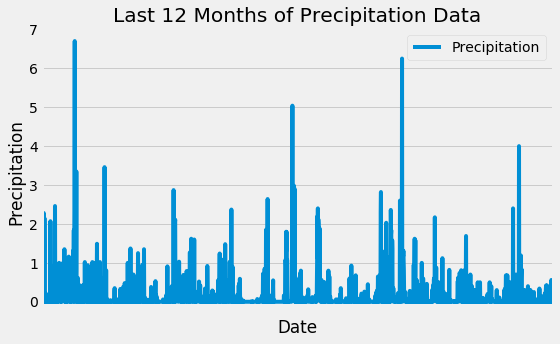

In [13]:
# Sort the dataframe by date
yearlyPrec_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
yearlyPrec_df.plot(figsize=(8,5))
plt.xticks([])
plt.legend(['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.tight_layout()
plt.savefig('Images/precipitation_analysis.png')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yearlyPrec_df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
countStation = session.query(Station).count()
print(countStation)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
countStation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
countStation = {station: ct for station, ct in countStation}
for station,ct in countStation.items():
    print(station,ct)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
listStation = list(countStation)
topStation = listStation[0]
temp_topStation = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == topStation).all()
print(temp_topStation)

[(54.0, 85.0, 71.66378066378067)]


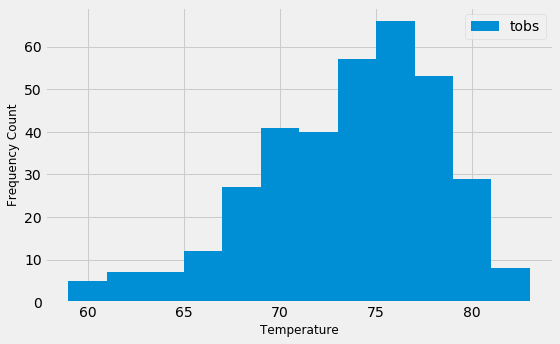

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearTemp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).filter(Measurement.station == topStation).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
yearTemp_df = pd.DataFrame(yearTemp,columns=['Date','TOBS'])
yearTemp_df = yearTemp_df.set_index('Date')

# Sort dataframe by date values
yearTemp_df.sort_values(by='Date')
yearTemp_df.head()

#Plot the results as a histogram
plt.figure(figsize=(8,5))
plt.hist(yearTemp_df['TOBS'].values,bins=12)
plt.legend(['tobs'],loc='best')
plt.ylabel('Frequency Count',size=12)
plt.xlabel('Temperature',size=12)
plt.tight_layout()
plt.savefig('Images/temperatureobservations_analysis.png')
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp = calc_temps('2017-02-28', '2017-03-05')
print(temp)

[(64.0, 72.02777777777777, 78.0)]


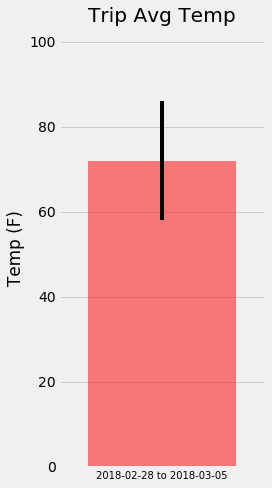

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
loTemp, avgTemp, hiTemp = temp[0]
plt.figure(figsize=(4,7))
plt.bar(1,avgTemp,width=.5,yerr=[hiTemp-loTemp],color='red',alpha=0.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.xlabel('2018-02-28 to 2018-03-05',fontsize=10)
plt.margins(.2)
plt.yticks(np.arange(0,120,20))
plt.tight_layout()
plt.savefig('Images/avgtemperature_analysis.png')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_startDate = '2017-02-28'
trip_lastDate = '2017-03-05'
rainTotal = session.query(Measurement.station,func.sum(Measurement.prcp)).filter(Measurement.date >= trip_startDate).filter(Measurement.date <= trip_lastDate).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

rainTotal_result = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation, func.sum(Measurement.prcp))\
                  .filter(Measurement.date >= trip_startDate)\
                  .filter(Measurement.date <= trip_lastDate)\
                  .filter(Measurement.station == Station.station)\
                  .group_by(Measurement.station)\
                  .order_by(func.sum(Measurement.prcp).desc())\
                  .all()

rainTotal_result

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.720000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.07),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1600000000000001)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip 
# push each tuple of calculations into a list called `normals`
normals = []

In [25]:
# Set the start and end date of the trip
journey_startDate_ = pd.to_datetime(trip_startDate)
journey_lastDate = pd.to_datetime(trip_lastDate)

In [26]:
#going a bit further - using timedelta to add additional precision to the time stamps.
startDate_precision = journey_startDate_ + dt.timedelta(days=365)
endDate_precision = journey_lastDate + dt.timedelta(days=365)

In [27]:
# Use the start and end date to create a range of dates
journeyPeriod = (journey_lastDate-journey_startDate_).days + 2
journeyRange = pd.Series(pd.date_range(trip_startDate,periods=journeyPeriod,freq='D'))
Period_precision = (endDate_precision-startDate_precision).days + 2
Range_precision = pd.Series(pd.date_range(startDate_precision.strftime('%Y-%m-%d'),periods=Period_precision,freq='D'))

In [28]:
# Stip off the year and save a list of %m-%d strings
list_dates = []
for i in journeyRange:
    list_dates.append(i.strftime('%m-%d'))

In [29]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for j in list_dates:
    normals.append(daily_normals(j))
normals

[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)]]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#Load query results as normals_df with additional cost to split the data into individual columns.
#Once columns are seperated, rename the columns
query_df = pd.DataFrame(normals)
query_df = query_df[0].apply(pd.Series)
query_df = query_df.rename(columns={0:'tmin',1:'tavg',2:'tmax'})

#Load the dates as a date_df and then combine to normals_df
date_df = pd.DataFrame(Range_precision)
query_df = pd.concat([date_df[:], query_df[:]], axis=1)

#Rename "date" column as date and then set the index to that column
query_df = query_df.rename(columns={0:'date'})
query_df = query_df.set_index('date')

#Result
query_df

,tmin,tavg,tmax
date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0
2018-03-06,60.0,69.203390,76.0


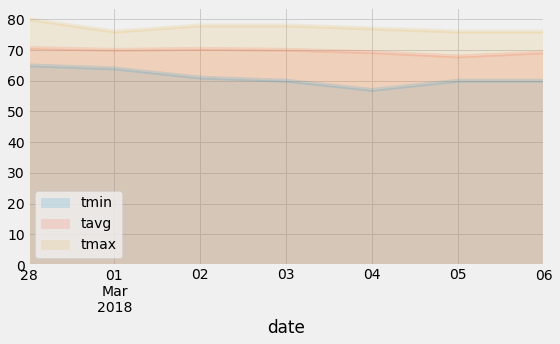

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
plt.style.use('fivethirtyeight')
query_df.plot.area(stacked=False,grid=True,alpha=0.15,figsize=(8,5))
plt.grid(b=True,which='both',axis='both')
plt.xlabel('date')
plt.tight_layout()
plt.savefig('Images/normals_analysis.png')
plt.show()